Am downloadat fisierele si le-am incarcat in google drive pentru a putea lucra cu ele in google colab. Cand le incarc din google drive, le transform in dataframes din pandas pentru a le analiza. Obser va am doar date de tip text in ambele fisiere.

In [58]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

details=pd.read_csv('/content/drive/MyDrive/veridion/insurance_details.csv')
details.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"


Observ ca sectorul este o eticheta care apartine unei multimi cu un numar mic de elemente asa ca afisez valorile unice si cate sunt din fiecare. Verific si daca valorile din business_tags,
 category si niche sunt dintr-o multime cu un numar mic de valori sau nu.

In [ ]:
details['sector'].value_counts()

,count
sector,
Manufacturing,4005
Services,3556
Wholesale,779
Retail,571
Government,255
Education,161
Non Profit,140


Realizez si un plot de tip bars pentru a vizualiza numarul de intrari din fiecare sector.

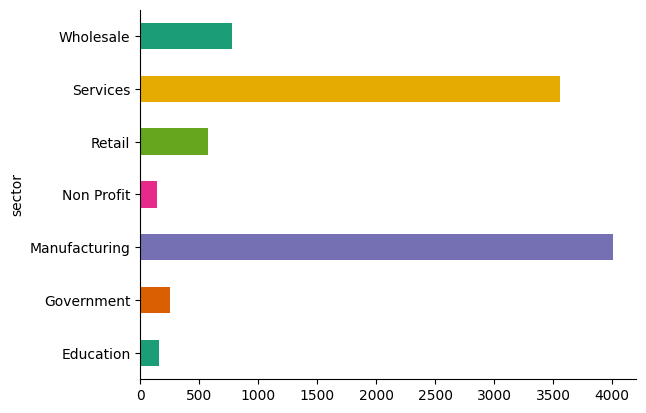

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
details.groupby('sector').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
details['category'].value_counts()

,count
category,
Farms & Agriculture Production,237
"Executive, Legislative & Government Institutions",172
Chemicals,150
Industrial Machinery & Supplies,126
Livestock & Animal Raising,121
...,...
Aquarium,1
Employment Attorneys,1
Electronics Repair & Maintenance,1


In [ ]:
details['niche'].value_counts()

,count
niche,
Apiculture,10
Other Heavy and Civil Engineering Construction,10
"Frozen Fruit, Juice, and Vegetable Manufacturing",10
All Other Miscellaneous Crop Farming,10
"Automotive Body, Paint, and Interior Repair and Maintenance",10
...,...
Pipeline Transportation of Natural Gas,2
Underground Coal Mining,2
Dimension Stone Mining and Quarrying,2


In [59]:
import ast

details['tags'] = details['business_tags'].apply(lambda s: [tag.lower() for tag in ast.literal_eval(s)])

all_tags = pd.DataFrame([tag for tags in details['tags'] for tag in tags],columns=['tag'])
all_tags['tag'].value_counts()


,count
tag,
retail,440
manufacturing,319
non-profit organization,219
research and development,186
wheelchair accessible entrance,171
...,...
mango farming,1
bamboo farming,1
qb series electric drivelines,1


Problema data este o problema de clasificare multi-label, dar datorita lipsei unui ground truth nu pot face supervised sau semi-supervised learning. Nu pot antrena un model de ML pe setul de date. Ce imi propun sa fac este sa calculez un scor de similaritate intre datele pe care le am si label-uri si sa le atribui pentru un anume prag.

Obser ca pentru niche category si tags, desi exista repetitii, exista multi outliers cu 1 sau 2 aparitii deci trebuie sa am grija la introducerea zgomotului in model. De aceea voi combina detaliile pentru o anumita companie intr-un singur text si voi folosi BERT pentru a calcula embeddings pentru tot textul combinat si respectiv pentru fiecare label din lista de insurance taxonomy.

Voi incepe prin a inlocui valorile de tip NaN cu un string gol pentru a nu avea erori in model si voi folosi lista de bussiness tags realizata anterior.

In [60]:
text_cols = ['description', 'tags', 'sector', 'category', 'niche']
details[text_cols] = details[text_cols].fillna('')

Combin textul din fiecare coloana pentru a avea o descriere complexa a fiecarei companii

In [ ]:
details['text'] = (
    "Description: " + details['description'] + ". " +
    "Tags: " + details['tags'].apply(lambda x: ', '.join(x)) + ". " +
    "Sector: " + details['sector'] + ". " +
    "Category: " + details['category'] + ". " +
    "Niche: " + details['niche']
)
details['text'].head()

,text
0,Description: Welchcivils is a civil engineerin...
1,Description: Kyoto Vegetable Specialists Uekam...
2,Description: Loidholdhof Integrative Hofgemein...
3,Description: PATAGONIA Chapa Y Pintura is an a...
4,Description: Stanica WODNA PTTK Swornegacie is...


In [ ]:
insurance_taxonomy=pd.read_csv('/content/drive/MyDrive/veridion/insurance_taxonomy.csv')
insurance_taxonomy.head()

,label
0,Agricultural Equipment Services
1,Soil Nutrient Application Services
2,Pesticide Application Services
3,Ornamental Plant Nurseries
4,Landscaping Services


Pentru ca datele sunt in engleza pot folosi mai multe modele de tip BERT. Totusi, am nevoie de embeddings pentru propozitii si voi folosi unul bazat pe sentence embeddings luat din frame-work-ul sentence_transformers.

In [61]:
from sentence_transformers import SentenceTransformer,  util

model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
label_embbedings = model.encode(insurance_taxonomy['label'], convert_to_tensor=True)
companies_embeddings = model.encode(details['text'].tolist(), convert_to_tensor=True)

Dupa ce am extras label embeddings si companies embeddings, unde companies embeddings contine toate datele despre companie intr-un singur text, calculez similitudinea folosind cosine scor-ul printr-o functie din sentence_transformers. Pentru fiecare eticheta, daca scorul de similaritate intre text si eticheta este mai mare decat un threshold ales la 0.4, consider eticheta ca fiind potrivita companiei. De asemenea pastrez si eticheta cu cel mai mare scor de similaritate.

In [ ]:
cosine_scores = util.cos_sim(companies_embeddings, label_embbedings)

def get_labels(scores, taxonomy, threshold=0.4):
    return [taxonomy[i] for i, score in enumerate(scores) if score >= threshold]

def get_top_label(scores, taxonomy):
    top_idx = scores.argmax().item()
    return taxonomy[top_idx]

details['insurance_label'] = [get_labels(row, insurance_taxonomy['label']) for row in cosine_scores]
details['top_label'] = [get_top_label(row, insurance_taxonomy['label']) for row in cosine_scores]

Pentru a evalua modelul analizez media valorilor celor mai mari similaritati pentru fiecare intrare si realizez un plot cu aceste top similaritati.

Scor mediu top-label similarity: 0.4125282
Distribuția scorurilor:


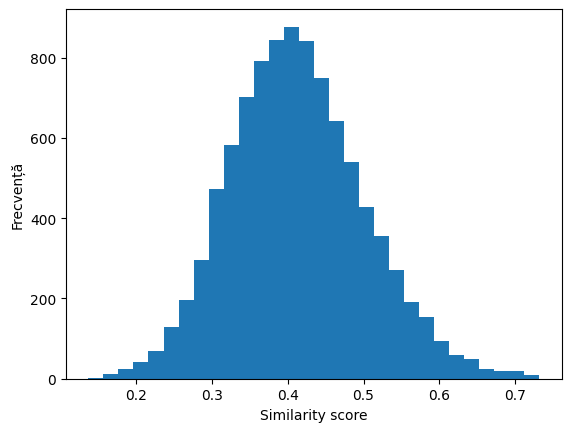

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
max_scores = cosine_scores.max(dim=1).values.cpu().numpy()

print("Scor mediu top-label similarity:", np.mean(max_scores))
print("Distribuția scorurilor:")
plt.hist(max_scores, bins=30)
plt.xlabel("Similarity score")
plt.ylabel("Frecvență")
plt.show()


Ce pot observa este ca media pentru top-similarities este mica, de 0.41 ceea ce indica o performanta scazuta a clasificarii, asa ca trebuie sa incerc alta abordare.

Voi calcula embeddings pentru descrierea companiei si voi alege top 15 etichete din punct de vedere al similaritatii. Daca descrierea este sirul vid, atunci va trebui sa pastrez toate etichetele pentru etapa urmatoare

In [62]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

label_texts = insurance_taxonomy['label']
label_embeddings = model.encode(label_texts, convert_to_tensor=True, normalize_embeddings=True)

def get_top_n_labels(description, n):
    if not isinstance(description, str) or not description.strip():
        return [(label, 0.0) for label in label_texts]

    desc_embedding = model.encode(description, convert_to_tensor=True, normalize_embeddings=True)
    similarities = util.cos_sim(desc_embedding, label_embeddings)[0]
    top_indices = similarities.argsort(descending=True)[:n]
    top_indices = top_indices.cpu().numpy()
    return [(label_texts.iloc[i], similarities[i].item()) for i in top_indices]

details['top15_labels_from_description'] = details['description'].apply(
    lambda desc: get_top_n_labels(desc, 15)
)

Acum ca am cele mai potrivite labeluri extrase folosind descrierea, voi folosi restul informatiilor din coloanele tags, category si niche pentru a le valida.  Problema este ca in ceea ce priveste valorile din coloana sector, acestea pot creea o idee falsa de similaritate prin repetitia lor atat in category, niche, tags cat si in etichete. De aceea le voi elimina impreuna cu toate formele lor adiacente din coloanele tags, category si niche. Apoi voi calcula sentence embeddings pentru textul nou format. Pentru a putea elimina toate formele asemanatoare unui cuvant trebuie sa le aduc pe toate la lema lor folosind spacy.

In [63]:
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize_set(terms):
    lemmas = set()
    for term in terms:
        doc = nlp(term.lower().strip())
        lemmas.update([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])
    return lemmas

sector_terms_raw = details['sector'].unique()
sector_lemmas = lemmatize_set(sector_terms_raw)

def text_pentru_validare(row):
    fields = ['tags', 'category', 'niche']
    parts = []
    for field in fields:
        val = row.get(field, "")
        items = val if isinstance(val, list) else [str(val)]
        for item in items:
            doc = nlp(str(item).lower().strip())
            item_lemmas = [token.lemma_ for token in doc if token.is_alpha]
            if not any(lemma in sector_lemmas for lemma in item_lemmas):
                parts.append(" ".join(item_lemmas))
    return " ".join(parts)

details['text_pentru_validare'] = details.apply(text_pentru_validare, axis=1)

In [64]:
validare_embeddings = model.encode(details['text_pentru_validare'].tolist(), convert_to_tensor=True, normalize_embeddings=True)

Pentru embeddings de validare create voi calcula acum similitudinea intre etichetele gasite la pasul anterior si valorile calculate acum.

In [65]:
def get_validation(top15_labels, context_embedding):
    validated = []
    for label, sem_score in top15_labels:
        label_emb = model.encode(label, convert_to_tensor=True, normalize_embeddings=True)
        similarity = util.cos_sim(context_embedding, label_emb).item()
        validated.append({
            'label': label,
            'scor_initial': sem_score,
            'scor_validare': similarity
        })
    return validated

In [66]:
details['validated'] = [
    get_validation(top15, val_emb)
    for top15, val_emb in zip(details['top15_labels_from_description'], validare_embeddings)
]

In [67]:
def select_top_validated(validated, top_n=5,threshold=0.4):
    sorted_vals = sorted(validated, key=lambda x: x['scor_validare'] and x['scor_validare']>0.4, reverse=True)
    return [x['label'] for x in sorted_vals[:top_n]]

details['final_labels'] = details['validated'].apply(select_top_validated)

In [68]:
def top_val_score(validated_list):
    if validated_list:
        return max(x['scor_validare'] for x in validated_list)
    return 0

details['top_val_score'] = details['validated'].apply(top_val_score)

In [69]:
details_to_save = details[[
    'description',
    'business_tags',
    'sector',
    'category',
    'niche',
    'final_labels',
    'top_val_score'
]]

details_to_save.to_csv("labeled_results.csv", index=False)


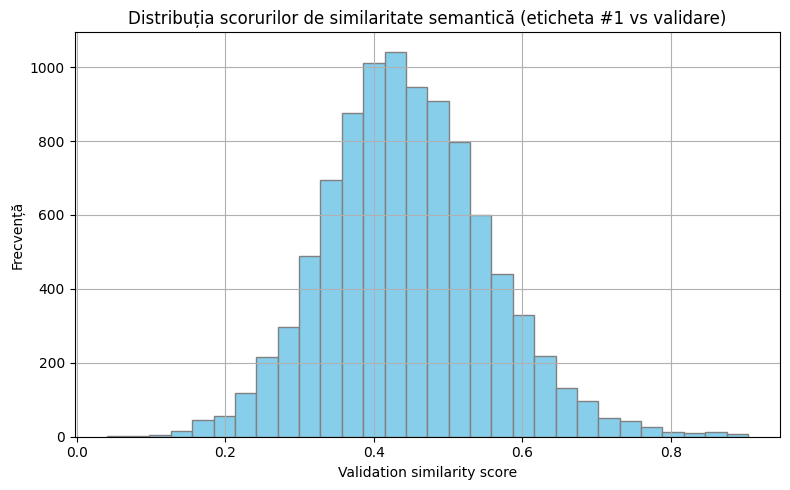

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(details['top_val_score'], bins=30, color='skyblue', edgecolor='gray')
plt.title("Distribuția scorurilor de similaritate semantică (eticheta #1 vs validare)")
plt.xlabel("Validation similarity score")
plt.ylabel("Frecvență")
plt.grid(True)
plt.tight_layout()
plt.show()
